# Option pricing function approximation with ANN

We first make some tools to price some European call options, and to generate some random sample of options prices.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

def bsm_eucall_price(S, K, tau, sigma, r=0, d=0):
    '''Black-Scholes-Merton call option price'''
    d1 = (np.log(S/K) + (r-d + 0.5*sigma**2)*tau)/(sigma*tau**0.5)
    d2 = d1 - sigma*tau**0.5
    price = np.exp(-d*tau)*S*norm.cdf(d1) -K*np.exp(-r*tau)*norm.cdf(d2)
    return(price)

## generate some parameters and option prices
##     - S = 1.0 : the underlying price is equal to one
##     - r = d = 0 : no risk-free rate or interest rate
def call_option_generator(n_sample, 
                          tau_range=[1/12, 1/2], 
                          sigmadev=2,
                          sigma_range=[0.1, 0.5]):
    '''
    generate random parameters and compute prices:
        - sigma, tau: uniformely
        - log(K/S): uniformely on +/-sigmadev*sigma*tau**0.5
    '''
    x = np.zeros([n_sample, 4], dtype='float')
    x[:,1] = np.random.uniform(tau_range[0], tau_range[1], n_sample)
    x[:,2] = np.random.uniform(sigma_range[0], sigma_range[1], n_sample)
    x[:,0] = np.random.uniform(-sigmadev, sigmadev, n_sample)
    x[:,0] = np.exp(x[:,2]*x[:,1]**0.5*x[:,0])
    ## price options
    ifunc = lambda x: bsm_eucall_price(1.0, x[0], x[1], x[2])
    x[:,3] = np.apply_along_axis(ifunc, 1, x[:,0:3])
    return(x)

Generate a data sample.

In [2]:
n_sample = 5000
np.random.seed(123)
data = call_option_generator(n_sample)

import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1], s=0.5, c=-data[:,2])
plt.gray()
plt.xlabel('K')
plt.ylabel('tau')
plt.show()

df = pd.DataFrame(data, columns=['K', 'tau', 'sigma', 'price'])
df.describe()

<Figure size 640x480 with 1 Axes>

,K,tau,sigma,price
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.020312,0.290610,0.299600,0.089041
std,0.204878,0.120976,0.114501,0.094868
min,0.526479,0.083362,0.100050,0.000412
25%,0.879320,0.184968,0.197257,0.012639
50%,1.005153,0.292374,0.301872,0.052653
75%,1.137676,0.393661,0.397180,0.139674
max,1.906169,0.499954,0.499750,0.475728


Prepare train and test data.

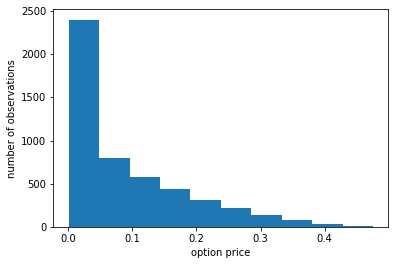

In [3]:
from sklearn.model_selection import train_test_split

y = data[:,3]
x = data[:,0:3]

plt.hist(y)
plt.xlabel('option price')
plt.ylabel('number of observations')
plt.show()

## make train and test datasets
test_size = 0.20
random_state = 123
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=test_size,
                                                    random_state=random_state)

Function to build an ANN model.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

def build_ann_model(input_dim=3, 
                    n_layer=2, 
                    n_neuron=20):
    ## another way to buid a keras model
    inputs = keras.Input(shape=(input_dim,), name='params')
    x = inputs
    for i in range(n_layer):
        x = layers.Dense(units=n_neuron, 
                         activation='relu',
                         use_bias=True,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         kernel_regularizer=None,
                         bias_regularizer=None,
                         activity_regularizer=None,
                         kernel_constraint=None,
                         bias_constraint=None,
                         name= 'hlayer_' + str(1+i)
                         )(x)
    outputs = layers.Dense(1, name='price')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='bsm_model')
    ## compile the model
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    return model

/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

Build and train a model.

In [5]:
model = build_ann_model(input_dim=3, n_layer=1, n_neuron=32) 
model.summary()

## params
batch_size = 128
epochs = 100

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)) ## val = set here

W1014 14:19:03.443097 140300613539648 deprecation.py:506] From /home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "bsm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
params (InputLayer)          [(None, 3)]               0         
_________________________________________________________________
hlayer_1 (Dense)             (None, 32)                128       
_________________________________________________________________
price (Dense)                (None, 1)                 33        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 0s 47us/sample - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 2/100
4000/4000 [==============================] - 0s 26us/sample - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch

Epoch 45/100
4000/4000 [==============================] - 0s 12us/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 46/100
4000/4000 [==============================] - 0s 10us/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 47/100
4000/4000 [==============================] - 0s 10us/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 48/100
4000/4000 [==============================] - 0s 11us/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 49/100
4000/4000 [==============================] - 0s 12us/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 50/100
4000/4000 [==============================] - 0s 11us/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0014 - val_mean_squared_

4000/4000 [==============================] - 0s 20us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 94/100
4000/4000 [==============================] - 0s 11us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 95/100
4000/4000 [==============================] - 0s 12us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 96/100
4000/4000 [==============================] - 0s 11us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 97/100
4000/4000 [==============================] - 0s 12us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 98/100
4000/4000 [==============================] - 0s 12us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011

Display fit and get predictions.


history dict: dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


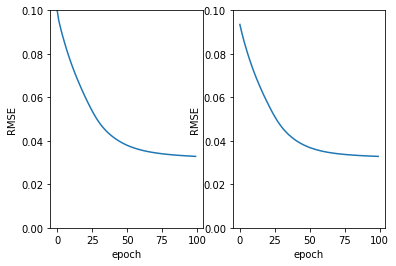


# Evaluate on test data
1000/1000 [==============================] - 0s 10us/sample - loss: 0.0011 - mean_squared_error: 0.0011
test loss, test acc: [0.0010785013297572733, 0.0010785013]

# Generate predictions


,price
count,1000.000000
mean,0.086728
std,0.084991
min,-0.109343
25%,0.021822
50%,0.070982
75%,0.143081
max,0.373983


In [6]:
# history = loss values and metric values during training
print('\nhistory dict:', history.history.keys())
plt.subplot(1, 2, 1)
plt.plot(history.epoch, np.array(history.history['mean_squared_error'])**0.5)
plt.ylim(0, 0.1)
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.subplot(1, 2, 2)
plt.plot(history.epoch, np.array(history.history['val_mean_squared_error'])**0.5)
plt.ylim(0, 0.1)
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

# evaluate
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# predictions
print('\n# Generate predictions')
predictions = model.predict(x_test[:,0:3])
pd.DataFrame({'price' : predictions.squeeze()}).describe()

## Exercises

* What do remark about the price prediction values? Are some values possible? How can you arrange that?
* Are the relative price errors the same? How can arrange/engineer that?
* Build, train, and evaluate models with different features
    * number of layers and number of parameters
    * optimizer choice (e.g. SGD versus Adam)
    * with and without dropout
    * with and without parameter regularization
* Which model is the best?
* If you can (computationally speaking) enlarge the parameters range and number of parameter sets. Is your best model the same?

In [7]:
# a useful function to create parameter sets
import itertools

param_list = [
    ['sgd', 'adam'],
    [1, 2, 3],
    [True, False]
]

## the star '*' is important here
for element in itertools.product(*param_list):
    print(element)
    model = build_ann_model(input_dim=3, n_layer=1, n_neuron=32) 
    model.summary()

    ## params
    batch_size = 128
    epochs = 100

    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)) ## val = set here

('sgd', 1, True)
('sgd', 1, False)
('sgd', 2, True)
('sgd', 2, False)
('sgd', 3, True)
('sgd', 3, False)
('adam', 1, True)
('adam', 1, False)
('adam', 2, True)
('adam', 2, False)
('adam', 3, True)
('adam', 3, False)
